Written by Nick Easton for the Zooniverse LSST Project. 
<br> July, 2017

Create a script to query the Ptf database for sources of given constraints. 
Then compile lightcurves and phase folded lightcurves for the returned sources.

In [2]:
import numpy as np
from astropy.table import Table as tbl
import urllib.request
import urllib.parse
import subprocess
import matplotlib.pyplot as plt
from cesium import featurize as feat
%matplotlib inline

## Query for the given objects

In [ ]:
url = "http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?"

In [ ]:
values = {'catalog':'ptf_objects', 'spatial':'None', 'outfmt':'1', 'selcols':'ra,dec,oid', 'constraints':'(bestchisq>100)and(ngoodobs>500)'}

In [ ]:
subprocess.call('curl -F catalog=ptf_objects -F spatial=None -F outfmt=1 -F selcols=ra,dec,oid -F constriants="(bestchisq>100)and(ngoodobs>500)" "http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?" -o objects.tbl', shell = True)

Im not sure why subprocess.call doesnt seem to work for this specific case. However, the urllib work below does the job.

In [ ]:
%%timeit
data = urllib.parse.urlencode(values)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
resp = urllib.request.urlopen(req)
respdata = resp.read()
saveFile = open('objects.tbl', 'wb')
saveFile.write(respdata)
saveFile.close()

### Read that data file in

In [7]:
objects = tbl.read('/home/nke2/NUREU17/LSST/VariableStarClassification/scripts/ptf_query/objects.tbl', format = 'ipac')

If reading in for the first times then use this cell. This will loop over each oid within the objects queried above and excute queries for their source lightcurves. Additionally, reads that returned data file into a dict to reference later.

In [9]:
curves = {}
for i in range(0,3):
    cmd = 'curl -F catalog=ptf_lightcurves -F spatial=None -F constraints=' + '"(oid={:})"'.format(objects['oid'][i]) + ' -F outfmt=1 -F selcols=obsmjd,mag_autocorr,magerr_auto,oid,fid,ra,dec "http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query?" -o curves_oid{:_>17}.tbl'.format(objects['oid'][i])
    subprocess.call(cmd, shell = True)
    curves[i] = tbl.read('curves_oid{:_>17}.tbl'.format(objects['oid'][i]), format = 'ipac')

Same as above. However, if the sources have already been queried just reads in the files to save some time.

In [21]:
curves = {}
for i in range(0,3):
    curves[i] = tbl.read('curves_oid{:_>17}.tbl'.format(objects['oid'][i]), format = 'ipac')

In both of the above cases, the loop has been shortened to so it the script doesnt exceed memory or storage limits (and so I could interact with it much quicker).

Plots the raw lightcurves together in a table. Some data has been masked, there seem to be a series of observations whose magnitudes where substantiantally inaccurate.

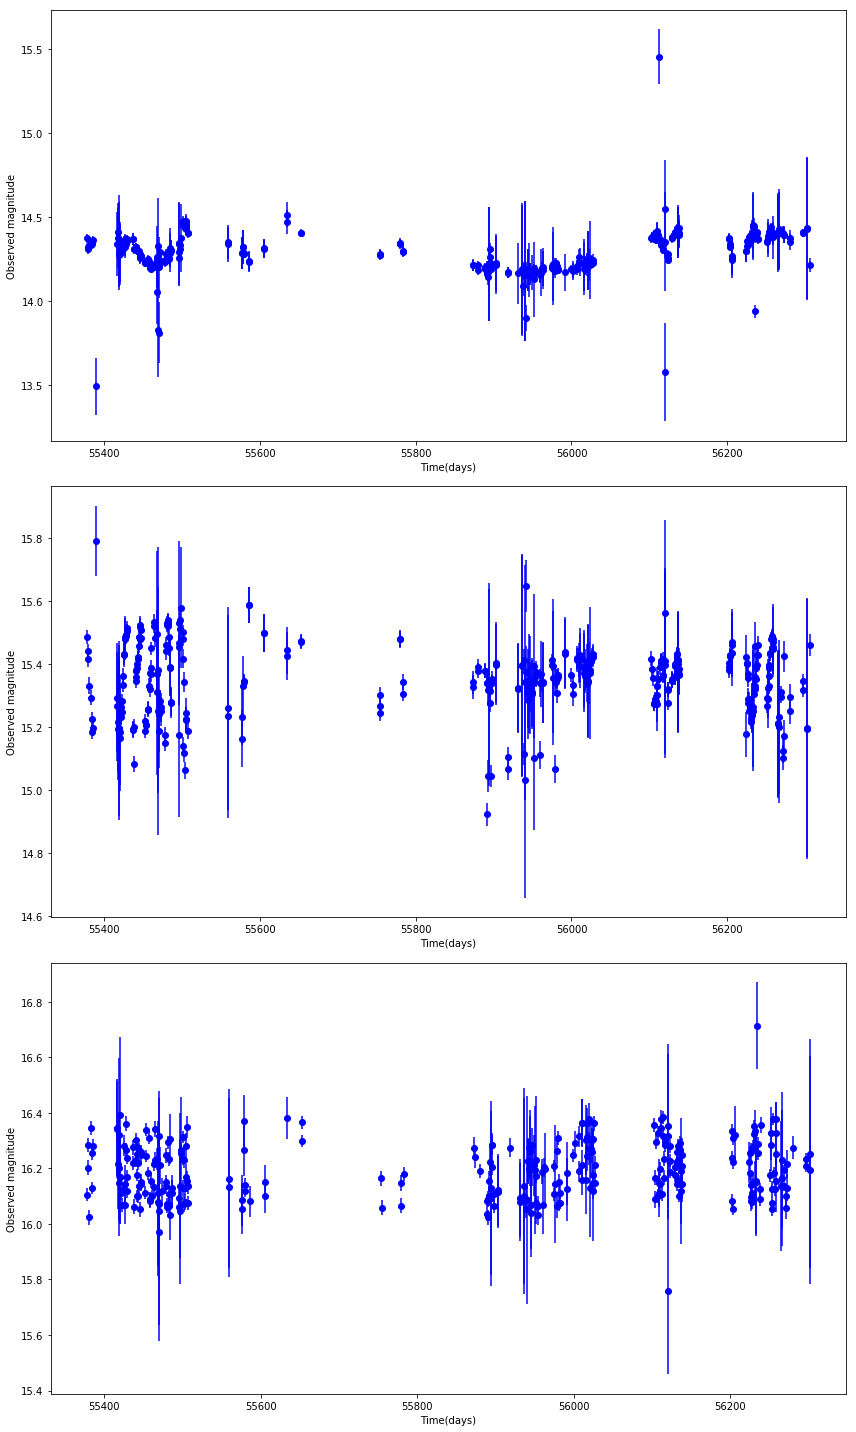

In [11]:
fig = plt.figure(figsize = (12, 20))
for i in range(0,3):
    ax = fig.add_subplot(3,1,i+1)
    masked = np.where(curves[i]['mag_autocorr'] > 0 )
    ax.errorbar(curves[i]['obsmjd'][masked], curves[i]['mag_autocorr'][masked], yerr = curves[i]['magerr_auto'][masked], fmt = 'bo')
    ax.set_xlabel('Time(days)')
    ax.set_ylabel('Observed magnitude')
    
plt.tight_layout()

### Phase folded curves
Each lightcurve has been phase folded with the first frequency Lomb-Scargyle detects. It is no surprise that the 3 first sources are not periodic.

/home/nke2/miniconda3/envs/tmpJupyter/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


1.00156182622


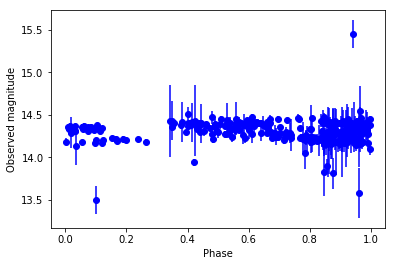

In [14]:
feats_to_use = ["freq1_freq"]
want = np.where(curves[0]['mag_autocorr'] > 0)
fset = feat.featurize_time_series(times = curves[0]['obsmjd'][want], values = curves[0]['mag_autocorr'][want], errors = curves[0]['magerr_auto'][want], features_to_use = feats_to_use)

per1 = fset['freq1_freq'][0][0]
print(per1)

plt.errorbar((curves[0]['obsmjd'][want]%per1)/per1, curves[0]['mag_autocorr'][want], yerr = curves[0]['magerr_auto'][want], fmt = 'bo')
plt.xlabel('Phase')
plt.ylabel('Observed magnitude')

/home/nke2/miniconda3/envs/tmpJupyter/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


0.0566304253118


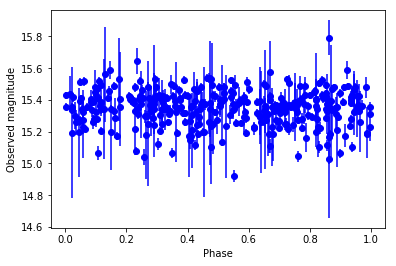

In [15]:
feats_to_use = ["freq1_freq"]
want = np.where(curves[1]['mag_autocorr'] > 0)
fset = feat.featurize_time_series(times = curves[1]['obsmjd'][want], values = curves[1]['mag_autocorr'][want], errors = curves[1]['magerr_auto'][want], features_to_use = feats_to_use)

per1 = fset['freq1_freq'][0][0]
print(per1)

plt.errorbar((curves[1]['obsmjd'][want]%per1)/per1, curves[1]['mag_autocorr'][want], yerr = curves[1]['magerr_auto'][want], fmt = 'bo')
plt.xlabel('Phase')
plt.ylabel('Observed magnitude')

/home/nke2/miniconda3/envs/tmpJupyter/lib/python3.6/site-packages/dask/async.py:13: UserWarning: `dask.async.get_sync` has been moved to `dask.local.get_sync`, please update your imports
  warnings.warn(_msg.format('get_sync'))


3.32906788176


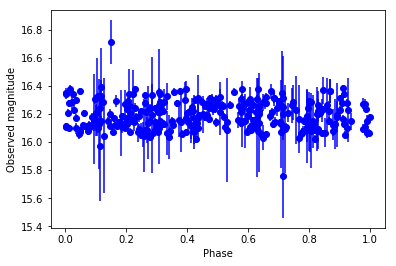

In [16]:
feats_to_use = ["freq1_freq"]
want = np.where(curves[2]['mag_autocorr'] > 0)
fset = feat.featurize_time_series(times = curves[2]['obsmjd'][want], values = curves[2]['mag_autocorr'][want], errors = curves[2]['magerr_auto'][want], features_to_use = feats_to_use)

per1 = fset['freq1_freq'][0][0]
print(per1)

plt.errorbar((curves[2]['obsmjd'][want]%per1)/per1, curves[2]['mag_autocorr'][want], yerr = curves[2]['magerr_auto'][want], fmt = 'bo')
plt.xlabel('Phase')
plt.ylabel('Observed magnitude')

It would be nice if cesium returned a periodogram somewhere. This would be helpful to determine how well we can trust the reported period. Additionally, as discussed, it may prove useful to show Zooniverse users said periodogram.